# Deploying the Hybrid Test Bench Emulator Service

In this notebook we will deploy a service that emulates the Hybrid Test Bench PT, and subsequently create a service to store data into the time series database.

To get our service running do the followning:
1. Make sure you're in the root of our repository ([hybrid-test-bench](./))
2. Run the following command: 

```bash
    python -m startup.start_services
   ``` 

This will start both InfluxDB and RabbitMQ services. This way we can have a consistent environment accross all machines.

Access, usernames and passwords are the following:

- **InfluxDB:**
  - Local site: [http://localhost:8086/](http://localhost:8086/)
  - User: bench
  - Password: hybridtestbench

- **RabbitMQ:**
  - Local site: [http://localhost:15672/](http://localhost:15672/)
  - User: bench
  - Password: bench

Now you should be able to access these two services, and we'll continue from here.

## Hybrid Test Bench (PT) Emulator Service

The interface of the emulator is very similar to the example for the Incubator ([IncubatorDTCourse\1-Incubator-Service\1-Incubator-Service.ipynb](..\1-Incubator-Service\1-Incubator-Service.ipynb)).

Our service will produce a RabbitMQ message every 3 seconds, and that message will contain data that matches exactly the data produced by the real Hybrid Test Bench - at least that is what we are trying to replicate.

The main difference is that, unlike the real Hybrid Test Bench, we will have to code the behavior that corresponds to applying a force on a specific beam. We will trigger this behavior using a RabbitMQ message that the emulator will listen for. This will lead to displacement, which we will show.


In [1]:
%%writefile logging.conf

[loggers]
keys=root,PTEmulatorService,HybridTestBenchDataRecorderInflux

[handlers]
keys=consoleHandler,PTEmulatorServiceFileHandler,HybridTestBenchDataRecorderInfluxFileHandler

[formatters]
keys=simpleFormatter

[logger_root]
level=DEBUG
handlers=consoleHandler

[logger_PTEmulatorService]
level=DEBUG
handlers=PTEmulatorServiceFileHandler
qualname=PTEmulatorService
propagate=0

[logger_HybridTestBenchDataRecorderInflux]
level=DEBUG
handlers=HybridTestBenchDataRecorderInfluxFileHandler
qualname=HybridTestBenchDataRecorderInflux
propagate=0

[handler_consoleHandler]
class=StreamHandler
formatter=simpleFormatter
args=(sys.stdout,)

[handler_PTEmulatorServiceFileHandler]
class=FileHandler
formatter=simpleFormatter
args=('PTEmulatorService.log', 'w')

[handler_HybridTestBenchDataRecorderInfluxFileHandler]
class=FileHandler
formatter=simpleFormatter
args=('HybridTestBenchDataRecorderInflux.log', 'w')

[formatter_simpleFormatter]
format=%(asctime)s.%(msecs)03d %(levelname)s %(name)s : %(message)s
datefmt=%Y-%m-%d %H:%M:%S

Overwriting logging.conf


In [2]:
import sys
import os

# Get the current working directory. Should be hybrid-test-bench
current_dir = os.getcwd()

assert os.path.basename(current_dir) == 'hybrid-test-bench', 'Current directory is not hybrid-test-bench'

# Get the parent directory. Should be the root of the repository
parent_dir = current_dir

# The root of the repo should contain the startup folder. Otherwise something went wrong during the inital setup.
assert os.path.exists(os.path.join(parent_dir, 'startup')), 'startup folder not found in the repository root'

# The root of the repo should contain the installation folder. Otherwise something went wrong during the inital setup.
assert os.path.exists(os.path.join(parent_dir, 'installation')), 'installation folder not found in the repository root'

bench_startup_dir = os.path.join(parent_dir, 'startup')

assert os.path.exists(bench_startup_dir), 'hybrid-test-bench startup directory not found'

# Add the parent directory to sys.path
sys.path.append(bench_startup_dir)

In [ ]:
%%writefile pt_emulator_service.py

# Configure python path to load hybrid test bench modules
import sys
import os
import logging
import logging.config
import time
import numpy as np

# Get the current working directory. Should be hybrid-test-bench
current_dir = os.getcwd()

assert os.path.basename(current_dir) == 'hybrid-test-bench', 'Current directory is not hybrid-test-bench'

# Get the parent directory. Should be the root of the repository
parent_dir = current_dir

from communication.server.rabbitmq import Rabbitmq
from communication.shared.protocol import ROUTING_KEY_STATE, ROUTING_KEY_FORCES
import pt_model as pt_model


class PTEmulatorService:
    
    def __init__(self, uh_initial, uv_initial, lh_initial, lv_initial, execution_interval, rabbitmq_config):

        self._rabbitmq = Rabbitmq(**rabbitmq_config)
        self._l = logging.getLogger("PTEmulatorService")

        self.uh = uh_initial
        self.uv = uv_initial
        self.lh = lh_initial
        self.lv = lv_initial
        # self.r = r_initial # do we need this for the emulator?
        self._execution_interval = execution_interval # seconds
        self._force_on = 0.0  

    def setup(self):
        self._rabbitmq.connect_to_server()

        # Declare local queues for the force messages
        self.forces_queue_name = self._rabbitmq.declare_local_queue(routing_key=ROUTING_KEY_FORCES)

        self._l.info(f"PTEmulatorService setup complete.")

    def _read_forces(self):
        msg = self._rabbitmq.get_message(self.forces_queue_name)
        if msg is not None:
            return msg["forces"]
        else:
            return None
    
    def check_control_commands(self):
        # Check if there are control commands
        force_cmd = self._read_forces()
        if force_cmd is not None:
            self._l.debug(f"Force command: on={force_cmd}")
            self._force_on = 1.0 if force_cmd else 0.0

    def emulate_pt(self):

        # Call the main function or logic from the script
        model = pt_model.PtModel()
        u, lf, r = model.run_simulation()


        # Additional logic for the emulator can go here
        # _uh, _uv, _lh, _lv, and _r need to be extracted from the simulation results (u, lf, r)
        if self._force_on == 1.0:
            # Horizontal displacement
            self._uh = u[model.get_dof1_horizontal(), :]
            # Vertical displacement
            self._uv = u[model.get_dof1_vertical(), :]
            # Horizontal force
            self._lh = np.multiply(model.get_fhs(), 1)
            # Vertical force
            self._lv = lf[0, :]
            # Restoring force
            #self._r = r[?????] # in case we need this for the emulator, we can put it here
        else: 
            # If the force is off, set displacements and forces to zero
            self._uh = 0.0
            self._uv = 0.0
            self._lh = 0.0
            self._lv = 0.0
            #self._r = 0.0 # in case we need this for the emulator, we can put it here

        self._l.info("PT script executed successfully.")
        
    def send_state(self, time_start):
        timestamp = time.time_ns()
        # Publishes the new state
        message = {
            "measurement": "emulator",
            "time": timestamp,
            "tags": {
                "source": "emulator"
            },
            "fields": {
                "horizontal_displacement": float(self._uh[-1]) if isinstance(self._uh, (np.ndarray, list)) else float(self._uh),
                "vertical_displacement": float(self._uv[-1]) if isinstance(self._uv, (np.ndarray, list)) else float(self._uv),
                "horizontal_force": float(self._lh[-1]) if isinstance(self._lh, (np.ndarray, list)) else float(self._lh),
                "vertical_force": float(self._lv[-1]) if isinstance(self._lv, (np.ndarray, list)) else float(self._lv),
                # "restoring_force": self._r.tolist() if isinstance(self._r, np.ndarray) else self._r,
                "force_on": self._force_on,
                "execution_interval": self._execution_interval,
                "elapsed": time.time() - time_start,
            }
        }

        self._rabbitmq.send_message(ROUTING_KEY_STATE, message)
        self._l.debug(f"Message sent to {ROUTING_KEY_STATE}.")
        self._l.debug(message)
    
    def start_emulation(self):
        # Start the emulation loop
        self._l.info("Starting PTEmulator emulation loop.")
        while True:
            time_start = time.time()
            #Check if there are control commands
            self.check_control_commands()
            # Emulate the PT behavior
            self.emulate_pt() 
            # Send the new state to the hybrid test bench physical twin
            self.send_state(time_start)
            # Sleep until the next sample
            time_end = time.time()
            time_diff = time_end - time_start
            if time_diff < self._execution_interval:
                time.sleep(self._execution_interval - time_diff)
            else:
                self._l.warning(f"Emulation loop took too long: {time_diff} seconds.")
    
if __name__ == "__main__":
    # Get utility functions to config logging and load configuration
    from pyhocon import ConfigFactory
    
    logging_conf = os.path.join(os.path.dirname(os.getcwd()), 'hybrid-test-bench', 'logging.conf')
    logging.config.fileConfig(logging_conf)

    # Get path to the startup.conf file used in the hybrid test bench PT & DT:
    startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'hybrid-test-bench', 'software','startup.conf')
    assert os.path.exists(startup_conf), 'startup.conf file not found'

    # The startup.conf comes from the hybrid test bench repository.
    config = ConfigFactory.parse_file(startup_conf)
    
    service = PTEmulatorService(
        uh_initial = 0.0,
        uv_initial = 0.0,
        lh_initial = 0.0,
        lv_initial = 0.0,
        # r_initial = 0.0,
        execution_interval = 3.0,
        rabbitmq_config=config["rabbitmq"])

    service.setup()
    
    # Start the PTEmulatorService
    service.start_emulation()

Overwriting pt_emulator_service.py


In [4]:
# You can run this, or you can run the command below in a new terminal windows to start the service
import subprocess
import time

# Start a process asynchronously
pt_emulator_service_proc = subprocess.Popen([sys.executable, "pt_emulator_service.py"])

# Wait for 5 seconds for the process to start
time.sleep(5)

# Print the PID of the process. You can search for this in your task manager to see the process running and kill it if necessary.
print(f"pt_emulator_service = {pt_emulator_service_proc.pid}")

pt_emulator_service = 4024


In [5]:
# Print contents of log file to verify that the service is running
with open('PTEmulatorService.log', 'r') as f:
    print(f.read())

# Check process hasn't crashed
assert pt_emulator_service_proc.poll() is None, "PTEmulatorService process has crashed"

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [6]:
from communication.server.rabbitmq import Rabbitmq
from communication.shared.protocol import ROUTING_KEY_FORCES

from pyhocon import ConfigFactory

# Get config
startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'hybrid-test-bench', 'software','startup.conf')
config = ConfigFactory.parse_file(startup_conf)

# Send a message to the PT to simulate the application of a force
with Rabbitmq(**config["rabbitmq"]) as rabbitmq:
    rabbitmq.send_message(ROUTING_KEY_FORCES, {"forces": True})

# Wait a bit for the message to be processed
time.sleep(5)

In [7]:
# Print contents of log file to verify that the service is running
with open('PTEmulatorService.log', 'r') as f:
    print(f.read())

# Check process hasn't crashed
assert pt_emulator_service_proc.poll() is None, "PTEmulatorService process has crashed"

2025-04-21 13:29:03.243 INFO PTEmulatorService : PTEmulatorService setup complete.
2025-04-21 13:29:03.243 INFO PTEmulatorService : Starting PTEmulator emulation loop.
2025-04-21 13:29:06.907 INFO PTEmulatorService : PT script executed successfully.
2025-04-21 13:29:06.909 DEBUG PTEmulatorService : Message sent to hybridtestbench.record.driver.state.
2025-04-21 13:29:06.909 DEBUG PTEmulatorService : {'measurement': 'emulator', 'time': 1745234946908162500, 'tags': {'source': 'emulator'}, 'fields': {'horizontal_displacement': 0.0, 'vertical_displacement': 0.0, 'horizontal_force': 0.0, 'vertical_force': 0.0, 'force_on': 0.0, 'execution_interval': 3.0, 'elapsed': 3.6646728515625}}
2025-04-21 13:29:06.909 WARNING PTEmulatorService : Emulation loop took too long: 3.6656620502471924 seconds.
2025-04-21 13:29:06.956 DEBUG PTEmulatorService : Force command: on=True
2025-04-21 13:29:07.880 INFO PTEmulatorService : PT script executed successfully.
2025-04-21 13:29:07.882 DEBUG PTEmulatorService :

In [8]:
pt_emulator_service_proc.terminate() # Terminate the process. Send SIGTERM signal to the process. The process can catch this signal and perform cleanup operations before exiting, so we wait.
pt_emulator_service_proc.wait()  # Wait for the process to exit fully. Should print exit code 1, due to interruption.

# Ensure process has exited
assert pt_emulator_service_proc.returncode is not None, 'Process has not exited'

## Data Recording Service

In this second part of the notebook, we deploy a service that subscribes to all relevant messages being exchanged, and stores them in the time series database, so that it can be visualized.

The key parts of this service are:
1. It subscribes to all messages going to a topic that's prefixed by `ROUTING_KEY_RECORDER="hybridtestbench.record.#"`. So a message sent to topic `hybridtestbench.record.driver.state` will also be received by the data recorder. Note that any other service that has declared a local queue attached to that topic will receive a copy of the message.
2. It uses the InfluxDB Client library to write the message data into the time series database. The message is already in the right format.

In [9]:
%%writefile hybrid_test_bench_data_recorder_influx.py

# Configure python path to load incubator modules
import sys
import os
import logging
import logging.config
import time

from influxdb_client import InfluxDBClient
from influxdb_client.client.write_api import SYNCHRONOUS

# Get the current working directory. Should be hybrid-test-bench
current_dir = os.getcwd()

assert os.path.basename(current_dir) == 'hybrid-test-bench', 'Current directory is not hybrid-test-bench'

# Get the parent directory. Should be the root of the repository
parent_dir = current_dir

# The root of the repo should contain the startup folder. Otherwise something went wrong during the inital setup.
assert os.path.exists(os.path.join(parent_dir, 'startup')), 'startup folder not found in the repository root'

# The root of the repo should contain the installation folder. Otherwise something went wrong during the inital setup.
assert os.path.exists(os.path.join(parent_dir, 'installation')), 'installation folder not found in the repository root'

bench_startup_dir = os.path.join(parent_dir, 'startup')

assert os.path.exists(bench_startup_dir), 'hybrid-test-bench startup directory not found'

# Add the parent directory to sys.path
sys.path.append(bench_startup_dir)

from communication.shared.protocol import ROUTING_KEY_RECORDER
from communication.server.rabbitmq import Rabbitmq

class HybridTestBenchDataRecorderInflux:
    def __init__(self, rabbitmq_config, influxdb_config):
        self._l = logging.getLogger("HybridTestBenchDataRecorderInflux")
        
        client = InfluxDBClient(**influxdb_config)
        write_api = client.write_api(write_options=SYNCHRONOUS)
        self.write_api = write_api
        self.influx_db_org = influxdb_config["org"]
        self.influxdb_bucket = influxdb_config["bucket"]

        self.rabbitmq = Rabbitmq(**rabbitmq_config)

    def read_record_request(self, ch, method, properties, body_json):
        self._l.debug("New record msg:")
        self._l.debug(body_json)
        self.write_api.write(self.influxdb_bucket, self.influx_db_org, body_json)

    def setup(self):
        self.rabbitmq.connect_to_server()

        self.rabbitmq.subscribe(routing_key=ROUTING_KEY_RECORDER,
                           on_message_callback=self.read_record_request)

    def start_recording(self):
        try:
            self.rabbitmq.start_consuming()
        except KeyboardInterrupt:
            self.rabbitmq.close()
    
if __name__ == "__main__":
    # Get utility functions to config logging and load configuration
    from pyhocon import ConfigFactory

    # Get logging configuration
    logging.config.fileConfig("logging.conf")

    # Get path to the startup.conf file used in the hybrid test bench PT & DT:
    startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'hybrid-test-bench', 'software','startup.conf')
    assert os.path.exists(startup_conf), 'startup.conf file not found'

    # The startup.conf comes from the hybrid test bench repository.
    config = ConfigFactory.parse_file(startup_conf)
    
    service = HybridTestBenchDataRecorderInflux(rabbitmq_config=config["rabbitmq"], influxdb_config=config["influxdb"])

    service.setup()
    
    # Start the HybridTestBenchDataRecorderInflux
    service.start_recording()

Overwriting hybrid_test_bench_data_recorder_influx.py


In [10]:
# Start a process asynchronously
pt_emulator_service_proc = subprocess.Popen([sys.executable, "pt_emulator_service.py"])

# Wait for 5 seconds for the process to start
time.sleep(5)

# Print the PID of the process. You can search for this in your task manager to see the process running and kill it if necessary.
print(f"pt_emulator_service = {pt_emulator_service_proc.pid}")

pt_emulator_service = 17844


In [11]:
# Start a process asynchronously
hybrid_test_bench_data_recorder_influx_proc = subprocess.Popen([sys.executable, "hybrid_test_bench_data_recorder_influx.py"])

# Wait for 5 seconds for the process to start
time.sleep(5)

# Print the PID of the process. You can search for this in your task manager to see the process running and kill it if necessary.
print(f"hybrid_test_bench_data_recorder_influx = {hybrid_test_bench_data_recorder_influx_proc.pid}")

hybrid_test_bench_data_recorder_influx = 16492


In [13]:
assert pt_emulator_service_proc.poll() is None, "PTEmulatorService process has crashed"
assert hybrid_test_bench_data_recorder_influx_proc.poll() is None, "HybridTestBenchDataRecorderInflux process has crashed"

In [15]:
# Print contents of log file to verify that the service is running
with open('HybridTestBenchDataRecorderInflux.log', 'r') as f:
    print(f.read())

2025-04-21 13:29:28.102 DEBUG HybridTestBenchDataRecorderInflux : New record msg:
2025-04-21 13:29:28.103 DEBUG HybridTestBenchDataRecorderInflux : {'measurement': 'emulator', 'time': 1745234968058095200, 'tags': {'source': 'emulator'}, 'fields': {'horizontal_displacement': 0.0, 'vertical_displacement': 0.0, 'horizontal_force': 0.0, 'vertical_force': 0.0, 'force_on': 0.0, 'execution_interval': 3.0, 'elapsed': 0.7686092853546143}}
2025-04-21 13:29:31.072 DEBUG HybridTestBenchDataRecorderInflux : New record msg:
2025-04-21 13:29:31.072 DEBUG HybridTestBenchDataRecorderInflux : {'measurement': 'emulator', 'time': 1745234971026348600, 'tags': {'source': 'emulator'}, 'fields': {'horizontal_displacement': 0.0, 'vertical_displacement': 0.0, 'horizontal_force': 0.0, 'vertical_force': 0.0, 'force_on': 0.0, 'execution_interval': 3.0, 'elapsed': 0.7353963851928711}}
2025-04-21 13:29:34.042 DEBUG HybridTestBenchDataRecorderInflux : New record msg:
2025-04-21 13:29:34.042 DEBUG HybridTestBenchDataR

On the InfluxDB management page, you should be able to query for the data coming from the emulator:

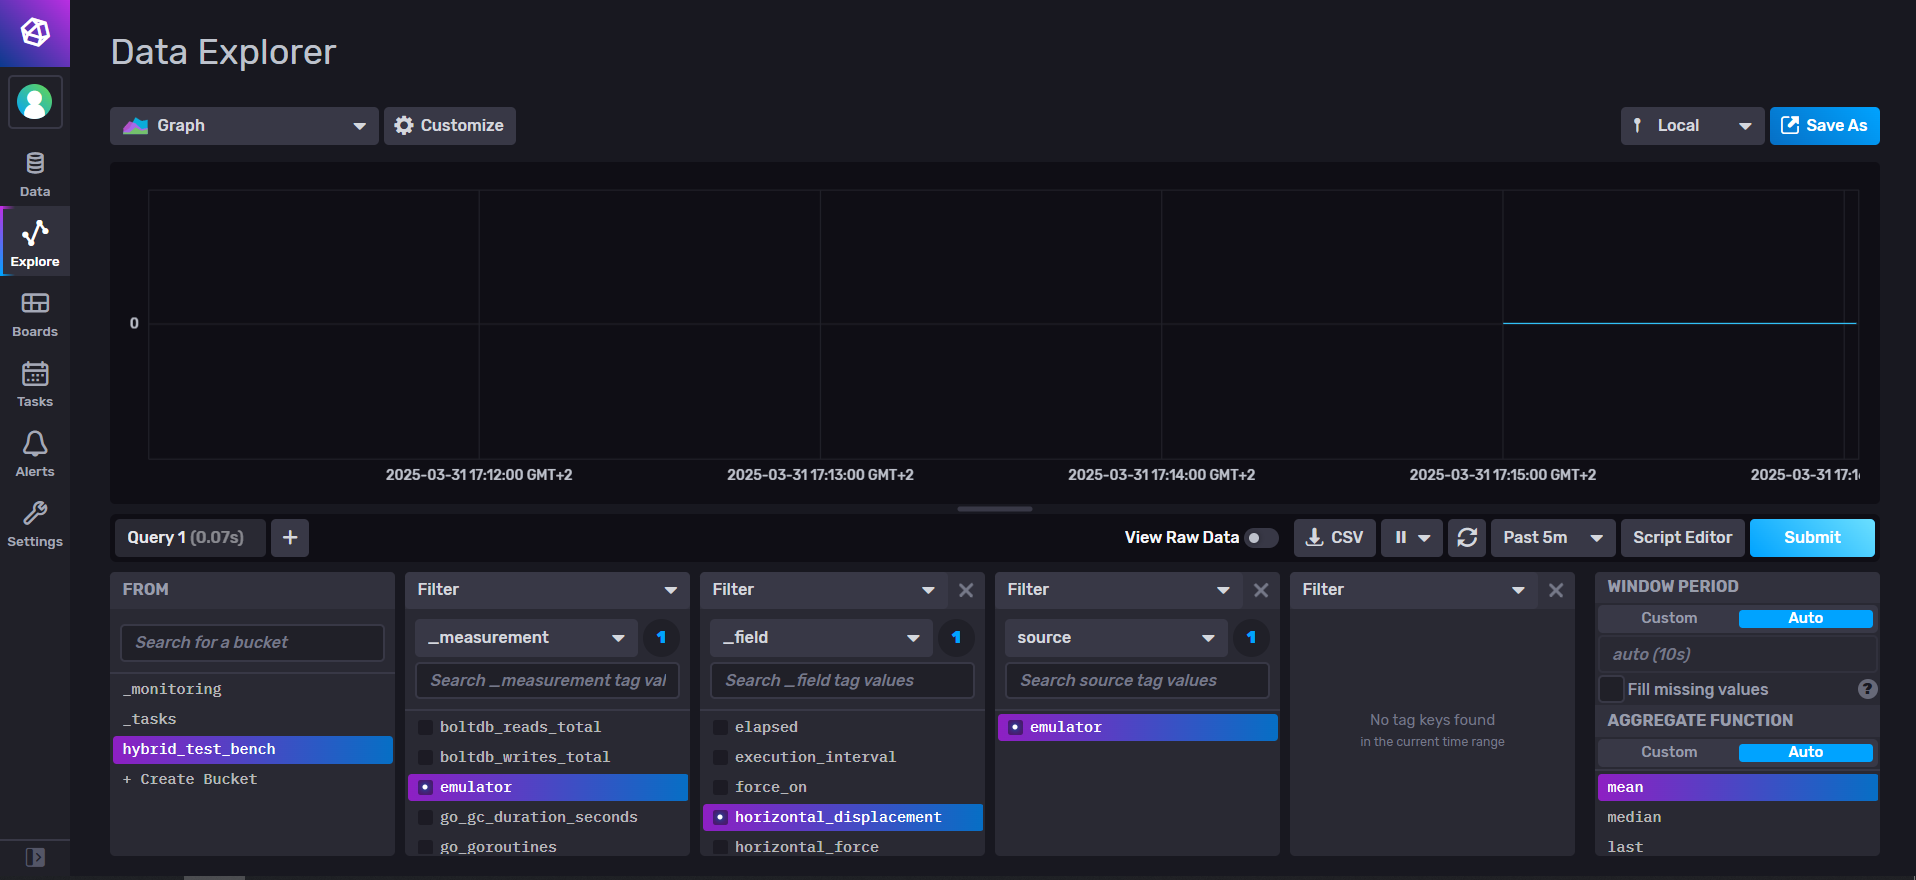

Let us now send the apply force message:

In [ ]:
# Get config
startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'hybrid-test-bench', 'software','startup.conf')
config = ConfigFactory.parse_file(startup_conf)

# Send a message to the PT to simulate application of force
with Rabbitmq(**config["rabbitmq"]) as rabbitmq:
    rabbitmq.send_message(ROUTING_KEY_FORCES, {"forces": True})

# Wait a bit for the message to be processed
time.sleep(5)

Here we kill the processes:

In [18]:
pt_emulator_service_proc.terminate() # Terminate the process. Send SIGTERM signal to the process. The process can catch this signal and perform cleanup operations before exiting, so we wait.
pt_emulator_service_proc.wait()  # Wait for the process to exit fully. Should print exit code 1, due to interruption.

# Ensure process has exited
assert pt_emulator_service_proc.returncode is not None, 'Process has not exited'

In [19]:
hybrid_test_bench_data_recorder_influx_proc.terminate() # Terminate the process. Send SIGTERM signal to the process. The process can catch this signal and perform cleanup operations before exiting, so we wait.
hybrid_test_bench_data_recorder_influx_proc.wait()  # Wait for the process to exit fully. Should print exit code 1, due to interruption.

# Ensure process has exited
assert hybrid_test_bench_data_recorder_influx_proc.returncode is not None, 'Process has not exited'